# Demo No. 11 - Radial velocities fitting.

Following 2 demos will illustrate, how to solve an inverse problem in case of the binary system with available radial velocities and photometric data. In this demo, we will focus on radial velocity fitting using couple of methods.


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook
import numpy as np
import astropy.units as u

from elisa import settings
from elisa.analytics import RVData, RVBinaryAnalyticsTask


# setting up a custom logging config to prevent unreasonably long log messages during fit
settings.configure(LOG_CONFIG='fit')
settings.set_up_logging()

As a start, we will create datasets containing observations of KIC 4851217 (Matson et al., 2017):

In [2]:
rv_primary = RVData.load_from_file('demo_data/rv_data/rv1.dat',  x_unit=u.d, y_unit=u.km/u.s)

rv_secondary = RVData.load_from_file('demo_data/rv_data/rv2.dat', x_unit=u.d, y_unit=u.km/u.s)

Lets finally define our starting parameters. Starting parameters are divided into `system`, `primary` and `secondary` categories listed in form of dictionaries that contain name of the variable as a key and values contains dictionaries characterizing starting value of the parameter, status of the parameter (`fixed`: True/False), the boundaries of the fitted parameter defined by `min`, `max` values and the unit in astropy format:

In [3]:
rv_init_params = {
    'system':{
        'eccentricity': {
            'value': 0.03,
            'fixed': False,
            'min': 0.00,
            'max': 0.04
        },
        'asini': {
            'value': 12,
            'fixed': False,
            'min': 8.0,
            'max': 15,
            'unit': u.solRad
        },
        'mass_ratio': {
            'value': 1.0,
            'fixed': False,
            'min': 0.9,
            'max': 1.2
        },
        'argument_of_periastron': {
            'value': 170,
            'fixed': False,
            'min': 0,
            'max': 360,
            'unit': u.deg
        },
        'gamma': {
            'value': -25.0,
            'fixed': False,
            'min': -30.0,
            'max': -10.0,
            'unit': u.km/u.s
        },
        'period': {
            'value': 2.47028376,
            'fixed': True,
        },
        'primary_minimum_time': {
            'value': 54953.8691,
            'fixed': False,
            'min': 54953.800,
            'max': 54954.000,
            'unit': u.d
        }
    }
}

This set of parameters is listed in format suitable for radial velocity fitting that uses parameters `system@asini`, `system@mass_ratio` instead of masses of the components (`primary@mass`, `secondary@mass`) and `system@inclination` parameter.

## Least squares method 

As a next step, we will create an `RVBinaryAnalyticsTask` on which we will perform fitting task itself utilizing least squares method:

In [19]:
lst_sqr_task = RVBinaryAnalyticsTask(data={'primary': rv_primary, 'secondary': rv_secondary}, method='least_squares')

Before fitting itself, you can access valid fit parameter combinations in `standard` or `community` format: 

In [20]:
print(lst_sqr_task.FIT_PARAMS_COMBINATIONS)

{
    "community": {
        "system": [
            "mass_ratio",
            "asini",
            "eccentricity",
            "argument_of_periastron",
            "gamma",
            "period",
            "primary_minimum_time"
        ]
    },
    "standard": {
        "primary": [
            "mass"
        ],
        "secondary": [
            "mass"
        ],
        "system": [
            "inclination",
            "eccentricity",
            "argument_of_periastron",
            "gamma",
            "period",
            "primary_minimum_time"
        ]
    }
}


Lets finally start the fit itself using the following command (it will take a few seconds to complete):

In [21]:
lst_sqr_results = lst_sqr_task.fit(x0=rv_init_params)
lst_sqr_results

2020-11-08 19:12:59,059 - 16363 - analytics.binary_fit.least_squares - INFO: fitting radial velocity light curve...
2020-11-08 19:13:04,607 - 16363 - analytics.binary_fit.least_squares - INFO: fitting finished...
2020-11-08 19:13:04,610 - 16363 - analytics.binary_fit.rv_fit - INFO: Fitting and processing of results finished successfully.

------------------------------------------------------------------------------------------------------------------------------
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                            1.077                   -                   -                None    Variable                                          
a*sin(i):                                          11.86       

{'system': {'eccentricity': {'value': 0.012708808027272438,
   'fixed': False,
   'unit': None,
   'min': 0.0,
   'max': 0.04},
  'argument_of_periastron': {'value': 262.05465837404364,
   'fixed': False,
   'unit': 'deg',
   'min': 0.0,
   'max': 360.0},
  'gamma': {'value': -24504.49649421677,
   'fixed': False,
   'unit': 'm / s',
   'min': -30000.0,
   'max': -10000.0},
  'mass_ratio': {'value': 1.0772968284393345,
   'fixed': False,
   'unit': None,
   'min': 0.9,
   'max': 1.2},
  'asini': {'value': 11.861383746081952,
   'fixed': False,
   'unit': 'solRad',
   'min': 8.0,
   'max': 15.0},
  'primary_minimum_time': {'value': 54953.87233532814,
   'fixed': False,
   'unit': 'd',
   'min': 54953.8,
   'max': 54954.0},
  'period': {'value': 2.47028376, 'fixed': True, 'unit': 'd'}},
 'r_squared': {'value': 0.9935344700692289, 'unit': None}}

We can see that the function provided a summary of the fit (which can be now accessed via command `task.result_summary(filename=)`) and returned the results in the same form as the starting parameters.

Finally, we can visualize the resulting fit along with observations:

In [7]:
lst_sqr_task.plot.model()

TypeError: 'NotImplementedType' object is not callable

We will now store the resulting parameters into the file that we will use later (parameters can be loaded using `lst_sqr_task.load_result(filename)`):

In [8]:
param_file = 'demo_data/assets/rv_lstsqr_params.json'
lst_sqr_task.save_result(param_file)

## Markov chain Monte Carlo (MCMC)

Using the MCMC we can estimate confidence intervals of the fitted parameters which was not possible in the least squares method. Unfortunatelly, this capability is at the expense of speed and therefore this method is meant to be used as a follow-up to the least squares method. To speed-up the initiall burn-in phase, we will use the results obtained in least squares method as a starting parameters

We have to also create a new fitting task instance dedicated with `mcmc` method specified: 

In [10]:
mcmc_task = RVBinaryAnalyticsTask(data={'primary': rv_primary, 'secondary': rv_secondary}, method='mcmc')

Updated starting parameters can be now used in a very similar fashion to the least squares method to perform MCMC sampling. Notice the `save` and `fit_id` parameter that is used to store fit results in Elisa `$HOME/mcmc_rv_fit/(fit_id).json`. You can also specify full path to the file in `fit_id_parameter`:

In [11]:
my_fit_id = "mcmc_rv_fit"

In [12]:
mcmc_results = mcmc_task.fit(x0=lst_sqr_results, nsteps=1000, burn_in=10, save=True, fit_id=my_fit_id, progress=True)
mcmc_results

2020-11-08 19:09:16,842 - 16363 - analytics.binary_fit.mcmc - INFO: starting mcmc
2020-11-08 19:09:16,843 - 16363 - analytics.binary_fit.mcmc - INFO: starting singlecore mcmc
2020-11-08 19:09:16,844 - 16363 - analytics.binary_fit.mixins - INFO: running burn-in...


100%|██████████| 10/10 [00:00<00:00, 79.38it/s]

2020-11-08 19:09:17,006 - 16363 - analytics.binary_fit.mixins - INFO: running production...



100%|██████████| 1000/1000 [00:16<00:00, 60.84it/s]


2020-11-08 19:09:33,581 - 16363 - analytics.binary_fit.mixins - INFO: MCMC chain, variable`s fitable and normalization constants were stored in: /home/miro/.elisa/mcmc_rv_fit/mcmc_rv_fit.json
2020-11-08 19:09:33,591 - 16363 - analytics.binary_fit.rv_fit - INFO: Fitting and processing of results finished successfully.

------------------------------------------------------------------------------------------------------------------------------
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                             1.08                0.02                0.01                None    Variable                                          
a*sin(i):                                           11.9                 0.2        

{'system': {'eccentricity': {'value': 0.013,
   'confidence_interval': {'min': 0.008, 'max': 0.018},
   'fixed': False,
   'min': 0.0,
   'max': 0.04,
   'unit': None},
  'argument_of_periastron': {'value': 284.0,
   'confidence_interval': {'min': 242.0, 'max': 319.0},
   'fixed': False,
   'min': 0.0,
   'max': 360.0,
   'unit': 'deg'},
  'gamma': {'value': -24520.0,
   'confidence_interval': {'min': -25040.0, 'max': -23980.0},
   'fixed': False,
   'min': -30000.0,
   'max': -10000.0,
   'unit': 'm / s'},
  'mass_ratio': {'value': 1.08,
   'confidence_interval': {'min': 1.06, 'max': 1.09},
   'fixed': False,
   'min': 0.9,
   'max': 1.2,
   'unit': None},
  'asini': {'value': 11.9,
   'confidence_interval': {'min': 11.7, 'max': 12.0},
   'fixed': False,
   'min': 8.0,
   'max': 15.0,
   'unit': 'solRad'},
  'primary_minimum_time': {'value': 54953.869,
   'confidence_interval': {'min': 54953.86, 'max': 54953.879},
   'fixed': False,
   'min': 54953.8,
   'max': 54954.0,
   'unit': 'd'

We can inspect the results by examining a correlation diagrams in the corner plot:

<IPython.core.display.Javascript object>


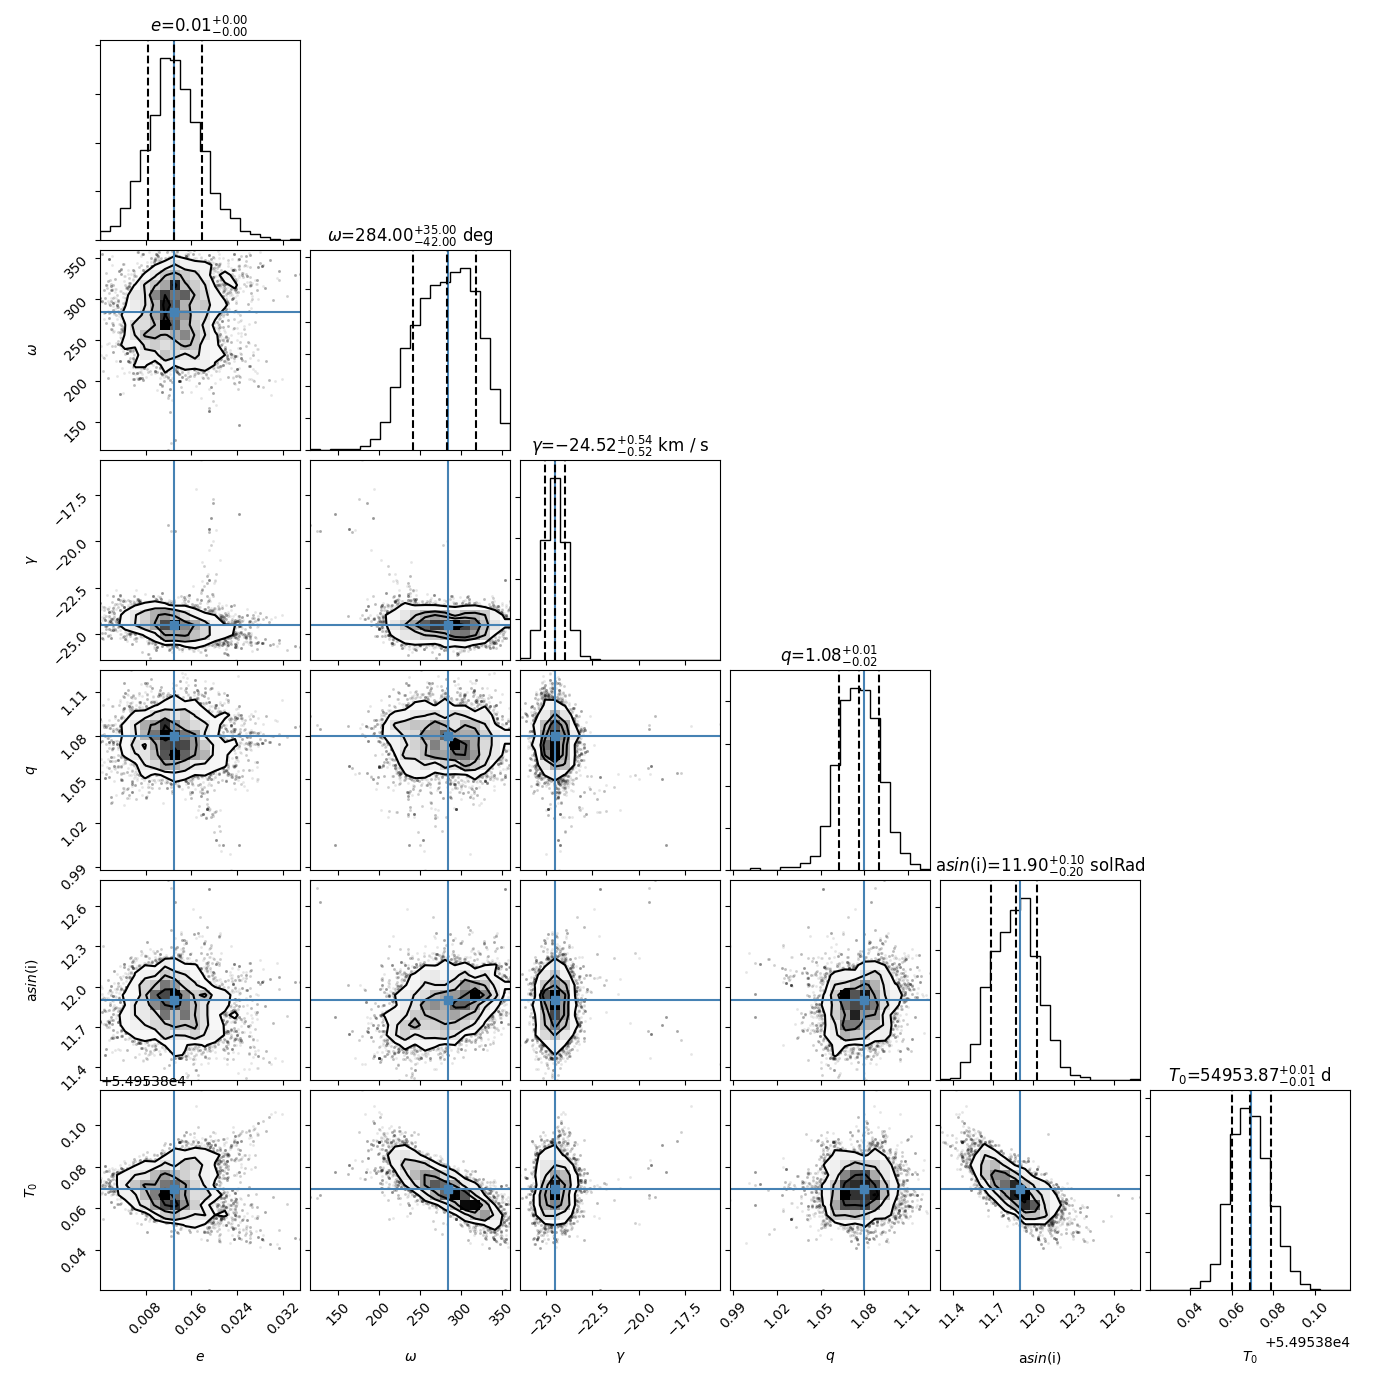

In [13]:
mcmc_task.plot.corner(truths=True)

Traces can be also investgated:

<IPython.core.display.Javascript object>


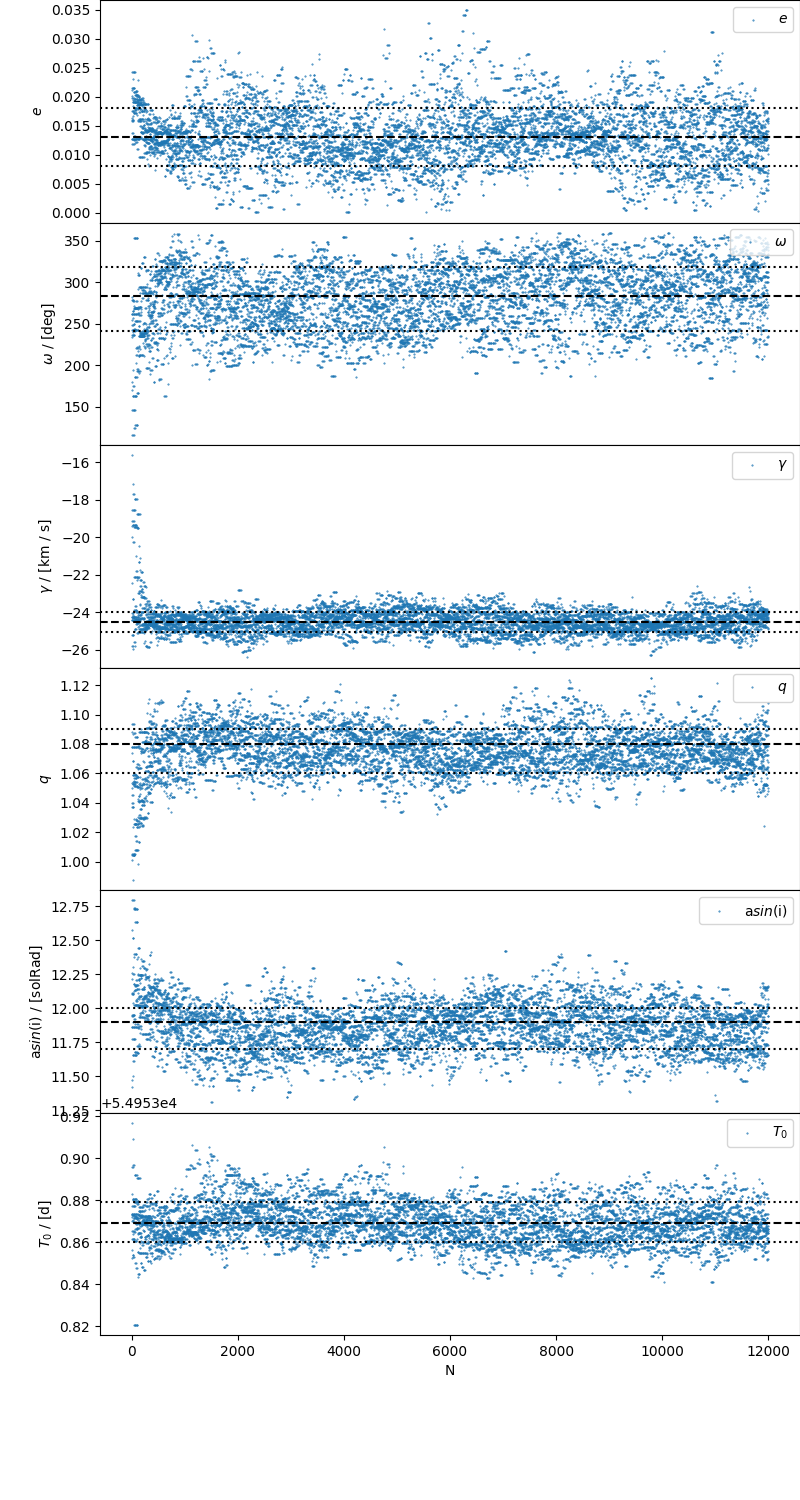

In [14]:
mcmc_task.plot.traces(truths=True)

Along with autocorrelation function and autocorrelation times:

<IPython.core.display.Javascript object>


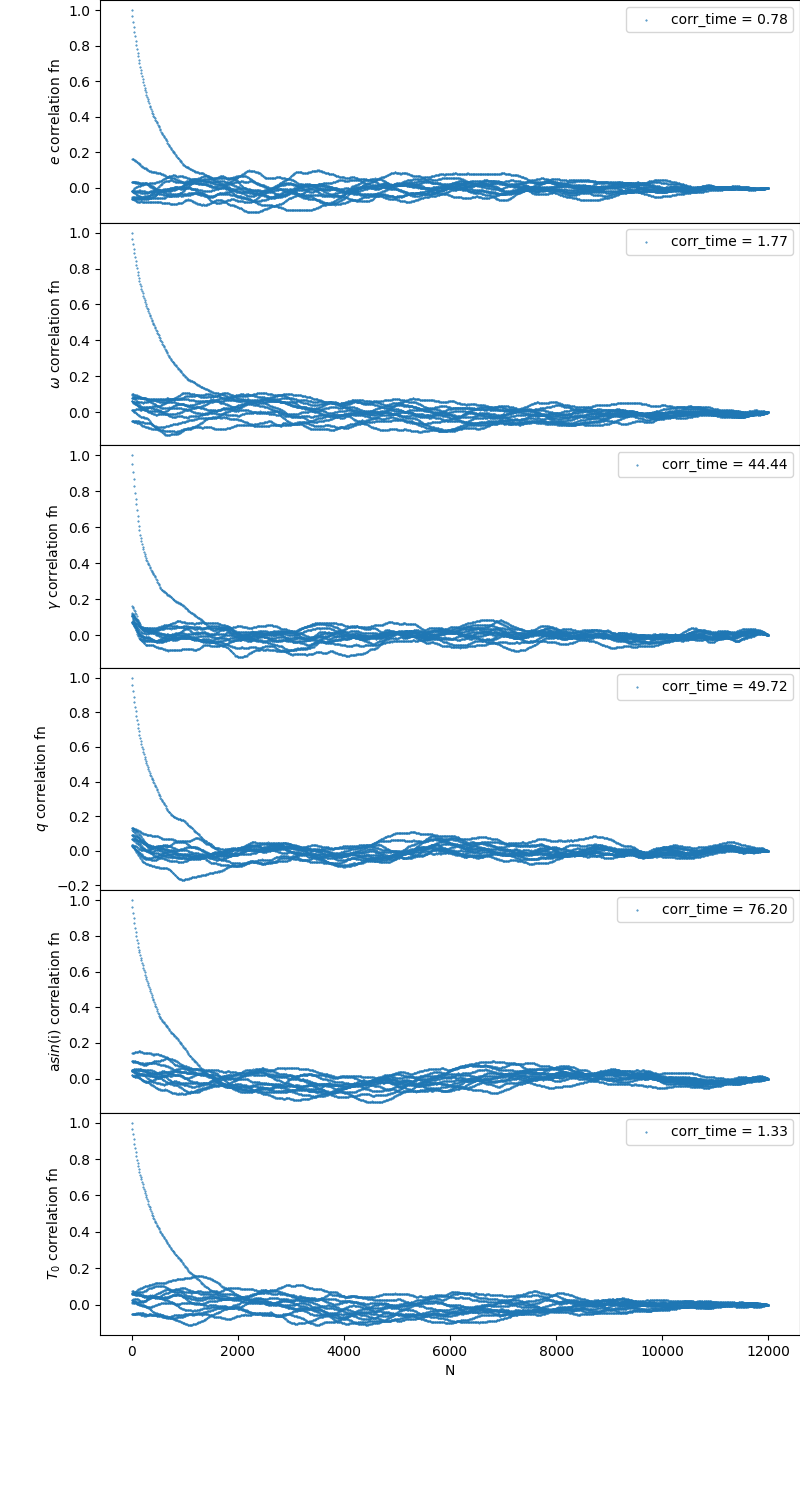

In [15]:
mcmc_task.plot.autocorrelation()

As you can (probably) see in this example, 10 steps in `burn_in` phase was not sufficient to de-correlate all of the chains. This can be remedied easily by incrasing the the number of iterations or by specifying longer `burn_in` argument in `fit` function.

Due to the fact, that the MCMC method is very time demanding method, the resulting chain can be recovered using your `fit_id` identificator (or path), where you can use `discard` parameter to filter out the thermalization stage of your chain:

In [16]:
mcmc_task.load_chain(my_fit_id, discard=1000)

Modified chain can be used to produce the more precise fit summary (where `filename` argument can be used to write the summary to file and 'propagate_errors' to do the complete error estimation of all model parameters):

In [17]:
mcmc_task.result_summary()


------------------------------------------------------------------------------------------------------------------------------
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                             1.08                0.02                0.01                None    Variable                                          
a*sin(i):                                           11.9                 0.2                 0.1              solRad    Variable                                          
Eccentricity (e):                                  0.013               0.005               0.005                None    Variable                                          
Argument of periastron (omega):                    284.0     

<IPython.core.display.Javascript object>


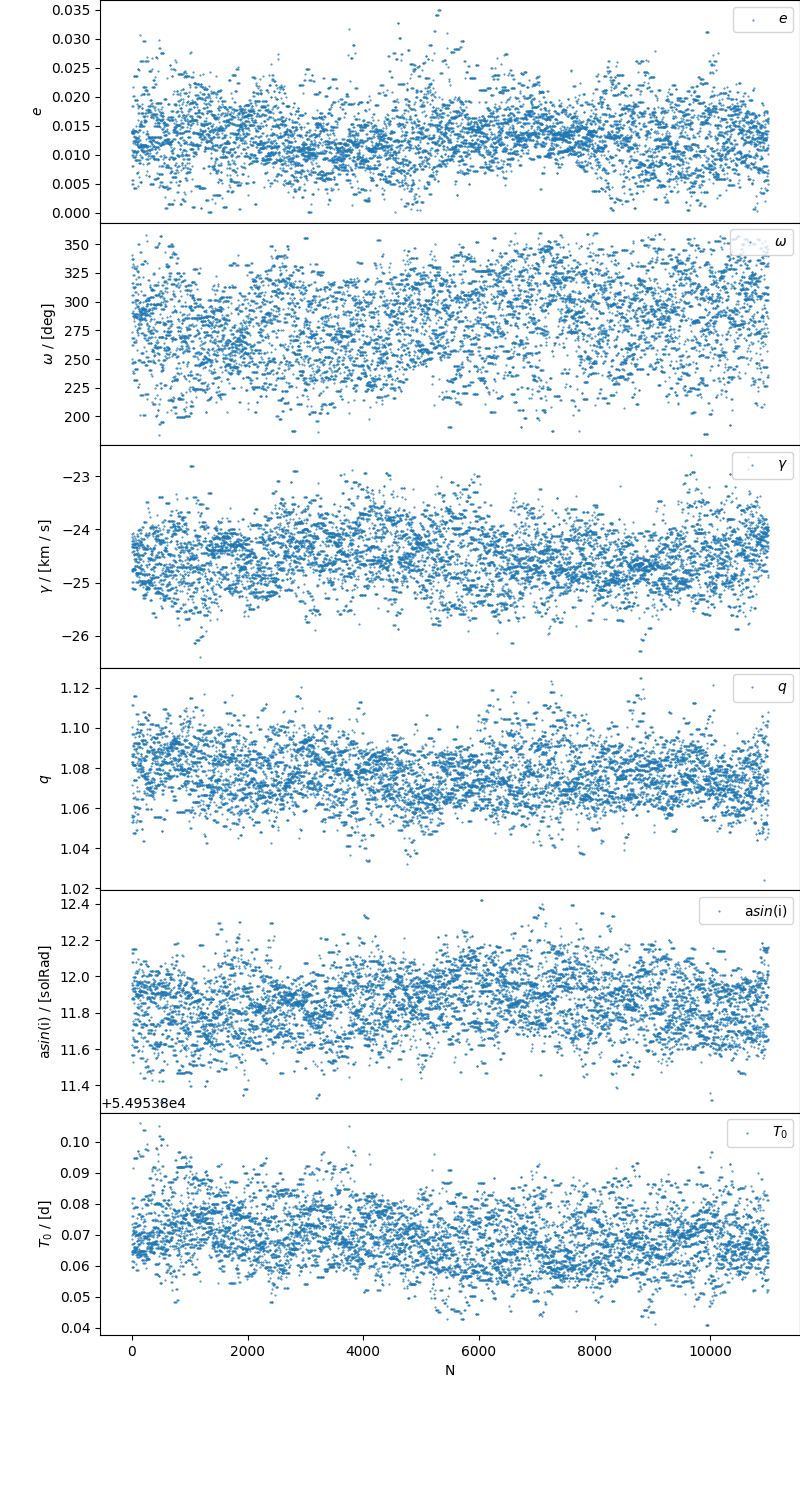

In [18]:
mcmc_task.plot.traces()

## References:

Matson, R. A.; Gies, D. R.; Guo, Z.; Williams, S. J. 2017, AJ, 154, 6, 216